<a href="https://colab.research.google.com/github/dr-irani/cs682-final-project/blob/master/notebooks/BERT_finetune_jigsaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print("No GPU available")
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


In [3]:
!pip install transformers
from transformers import BertTokenizer
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 645kB 8.1MB/s 
     |████████████████████████████████| 1.0MB 23.9MB/s 
     |████████████████████████████████| 890kB 39.1MB/s 
     |████████████████████████████████| 3.8MB 53.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=64b6a2f567934a01ae939f2188d158b2ee71da62e821441ece21becdf089b434
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your 

## 1. Load and Preprocess Data



In [4]:
!pip install -q kaggle
from google.colab import files
files.upload()  # choose your kaggle.json file
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification
!unzip train.csv.zip 
!unzip test.csv.zip

Saving kaggle.json to kaggle.json
 94% 261M/276M [00:04<00:00, 53.0MB/s]
100% 276M/276M [00:04<00:00, 68.6MB/s]
  0% 0.00/224k [00:00<?, ?B/s]
100% 224k/224k [00:00<00:00, 70.0MB/s]
 32% 5.00M/15.8M [00:00<00:00, 13.8MB/s]
100% 15.8M/15.8M [00:00<00:00, 39.4MB/s]
 41% 5.00M/12.3M [00:00<00:00, 14.0MB/s]
100% 12.3M/12.3M [00:00<00:00, 27.7MB/s]
 41% 5.00M/12.1M [00:00<00:00, 14.3MB/s]
100% 12.1M/12.1M [00:00<00:00, 30.7MB/s]
 57% 9.00M/15.9M [00:00<00:00, 18.7MB/s]
100% 15.9M/15.9M [00:00<00:00, 32.3MB/s]
 63% 41.0M/64.7M [00:01<00:00, 25.7MB/s]
100% 64.7M/64.7M [00:01<00:00, 60.8MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [5]:
df = pd.read_csv("/content/train.csv")

df.loc[df['target'] >= 0.5, 'target'] = 1
df.loc[df['target'] < 0.5, 'target'] = 0

df_race = df.loc[(df['black'] == 1) | (df['white'] == 1), ['target', 'comment_text', 'black', 'white']]
sentences = df_race.comment_text.tolist()
labels = df_race.target.tolist()

print('Train set size: ', df_race.shape[0])
print("Toxic: ", sum(labels), ", Non-toxic: ", len(labels)-sum(labels))
df_race.sample(10)

Train set size:  18520
Toxic:  5961.0 , Non-toxic:  12559.0


,target,comment_text,black,white
1283205,0.0,"What's with the racism? Why the ""white privil...",0.000000,1.00
828942,0.0,Because it is. Have a nice day\n From a White...,0.000000,1.00
1325446,0.0,Does diversity correlate to higher dividends f...,0.666667,1.00
1588463,1.0,"Hmm. Arab, crazy white guy, black dude with a ...",1.000000,1.00
1385340,0.0,How many years has this memorial stood without...,1.000000,0.75
738350,0.0,Why they are threat?\nGo to any town in southe...,0.000000,1.00
1689819,1.0,By her own logic one might surmise she's eithe...,0.000000,1.00
1753393,0.0,That Ryan Saavedra lied to the police claiming...,1.000000,0.00
278770,0.0,"""A report released by the FBI documented 12,76...",1.000000,1.00
165132,1.0,I HOPE people are waking up to the DAMAGING EF...,1.000000,1.00


###1.1 Tokenize Data 


Max sentence length:  327


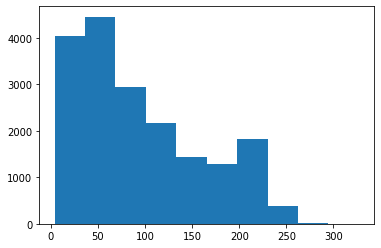

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Find maximum sentence length - don't run this multiple times. Our data is huge.
max_len = 0
sent_len = []
for sent in sentences:
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  max_len = max(max_len, len(input_ids))
  sent_len.append(len(input_ids))
print('Max sentence length: ', max_len)

import matplotlib.pyplot as plt
plt.hist(sent_len)
plt.show()

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
max_len = 256
# For every sentence...
for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels).long()


### 1.2 Training & Validation Split

In [8]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

16,668 training samples
1,852 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## 2. Finetune BERT

### 2.1 Load Model
I'm loading BertForSequenceClassification here.

In [10]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification..   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states. - hmm might have to check
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 2.2 Optimizer & Learning Rate Scheduler

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

###2.3 Training Loop

In [0]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [14]:
import random
import numpy as np
import os
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []
# Measure the total training time for the whole run.
total_t0 = time.time()

prev_val_loss = float('inf')

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    # If validation loss is lower than previous, save the model.
    if avg_val_loss < prev_val_loss:
      output_dir = './model_save/'

      if not os.path.exists(output_dir):
        os.makedirs(output_dir)
      print("Saving model to %s" % output_dir)

      # Save a trained model, configuration and tokenizer using `save_pretrained()`.
      # They can then be reloaded using `from_pretrained()`
      best_model = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
      best_model.save_pretrained(output_dir)
      tokenizer.save_pretrained(output_dir)
    prev_val_loss = avg_val_loss
      
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of  1,042.    Elapsed: 0:00:32.
  Batch    80  of  1,042.    Elapsed: 0:01:04.
  Batch   120  of  1,042.    Elapsed: 0:01:37.
  Batch   160  of  1,042.    Elapsed: 0:02:09.
  Batch   200  of  1,042.    Elapsed: 0:02:42.
  Batch   240  of  1,042.    Elapsed: 0:03:16.
  Batch   280  of  1,042.    Elapsed: 0:03:49.
  Batch   320  of  1,042.    Elapsed: 0:04:23.
  Batch   360  of  1,042.    Elapsed: 0:04:57.
  Batch   400  of  1,042.    Elapsed: 0:05:30.
  Batch   440  of  1,042.    Elapsed: 0:06:04.
  Batch   480  of  1,042.    Elapsed: 0:06:37.
  Batch   520  of  1,042.    Elapsed: 0:07:11.
  Batch   560  of  1,042.    Elapsed: 0:07:45.
  Batch   600  of  1,042.    Elapsed: 0:08:18.
  Batch   640  of  1,042.    Elapsed: 0:08:52.
  Batch   680  of  1,042.    Elapsed: 0:09:25.
  Batch   720  of  1,042.    Elapsed: 0:09:59.
  Batch   760  of  1,042.    Elapsed: 0:10:33.
  Batch   800  of  1,042.    Elapsed: 0:11:06.
  Batch   840  of  1,042.    Elapsed: 0:11:40.
  Batch   880

In [15]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.52,0.46,0.79,0:14:29,0:00:32
2,0.38,0.50,0.77,0:14:35,0:00:32
3,0.25,0.64,0.77,0:14:35,0:00:32
4,0.16,0.91,0.77,0:14:35,0:00:32


##3. Testing Model

###3.1 Load Test Data and Preprocess

In [16]:
df = pd.read_csv("/content/test.csv")

df.loc[df['target'] >= 0.5, 'target'] = 1
df.loc[df['target'] < 0.5, 'target'] = 0

df_race = df.loc[(df['black'] == 1) | (df['white'] == 1), ['target', 'comment_text', 'black', 'white']]
sentences = df_race.comment_text.tolist()
labels = df_race.target.tolist()

sentences = df_race.comment_text
labels = df_race.target

print('Test set size: ', df.shape[0])

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
max_len = 256
# For every sentence...
for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels).long()

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

KeyError: ignored

###3.2 Evaluate on Test Set

In [0]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

In [0]:
acc = np.count_nonzero(predictions==true_labels)/len(predictions)

##4. Save Model

In [0]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/Final Projects/Deep Learning/BERT Fine-Tuning/JIGSAWS"